In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [4]:
selected_cell = 'Tregs'

In [5]:
estimation = pd.read_csv('TCGA-LIHC.Immune.csv',index_col=0)
estimation.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,
TCGA-FV-A495-01,0.061526,0.036791,0.688189,0.098637,0.058827,0.009298,0.044200,0.002532,0,0.886827,0.467952
TCGA-G3-A3CH-11,0.098691,0.000000,0.738276,0.006164,0.104097,0.000367,0.049163,0.003243,0,0.919957,0.400423
TCGA-CC-A3MB-01,0.139905,0.032341,0.480762,0.118661,0.094536,0.044451,0.085290,0.004055,0,0.842832,0.582837
TCGA-BC-A3KF-01,0.114993,0.041077,0.596361,0.083589,0.062153,0.032894,0.067308,0.001626,0,0.791911,0.613901
TCGA-DD-A4NV-01,0.098896,0.002426,0.660500,0.058329,0.102381,0.027923,0.048503,0.001041,0,0.849245,0.532237


In [6]:
sample_list = [sample for sample in estimation.index.values if '-01' in sample]
estimation = estimation.reindex(sample_list)

In [7]:
survival_data = pd.read_csv('survival_LIHC_survival.txt',index_col=0,delimiter='\t')
sample_list = [sample for sample in survival_data.index.values if '-01' in sample]
survival_data = survival_data.reindex(sample_list)
survival_data.head()

,_PATIENT,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
sample,,,,,,,,,,
TCGA-2V-A95S-01,TCGA-2V-A95S,0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN
TCGA-2Y-A9GS-01,TCGA-2Y-A9GS,1,724.0,1.0,724.0,1.0,102.0,1,102.0,NaN
TCGA-2Y-A9GT-01,TCGA-2Y-A9GT,1,1624.0,1.0,1624.0,1.0,1083.0,1,1083.0,NaN
TCGA-2Y-A9GU-01,TCGA-2Y-A9GU,0,1939.0,0.0,1939.0,0.0,1939.0,0,1939.0,NaN
TCGA-2Y-A9GV-01,TCGA-2Y-A9GV,1,2532.0,1.0,2532.0,0.0,2532.0,1,1745.0,NaN


In [8]:
dfs_data = survival_data.filter(['DFI.time', 'DFI'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFI']]
dfs_data['DFS_T'] = [time/30 for time in dfs_data['DFI.time']]
dfs_data.head()

,DFI.time,DFI,DFS_E,DFS_T
sample,,,,
TCGA-2Y-A9GS-01,102.0,1.0,True,3.400000
TCGA-2Y-A9GT-01,1083.0,1.0,True,36.100000
TCGA-2Y-A9GU-01,1939.0,0.0,False,64.633333
TCGA-2Y-A9GV-01,2532.0,0.0,False,84.400000
TCGA-2Y-A9GW-01,1229.0,1.0,True,40.966667


In [9]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,DFI.time,DFI,DFS_E,DFS_T
TCGA-FV-A495-01,0.061526,0.036791,0.688189,0.098637,0.058827,0.009298,0.044200,0.002532,0,0.886827,0.467952,1.0,0.0,False,0.033333
TCGA-CC-A3MB-01,0.139905,0.032341,0.480762,0.118661,0.094536,0.044451,0.085290,0.004055,0,0.842832,0.582837,315.0,0.0,False,10.500000
TCGA-BC-A3KF-01,0.114993,0.041077,0.596361,0.083589,0.062153,0.032894,0.067308,0.001626,0,0.791911,0.613901,8.0,0.0,False,0.266667
TCGA-DD-A4NV-01,0.098896,0.002426,0.660500,0.058329,0.102381,0.027923,0.048503,0.001041,0,0.849245,0.532237,2398.0,0.0,False,79.933333
TCGA-BD-A3EP-01,0.112517,0.009514,0.552465,0.099583,0.098980,0.030022,0.094342,0.002577,0,0.731948,0.683071,409.0,0.0,False,13.633333


In [10]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,DFI.time,DFI,DFS_E,DFS_T
TCGA-DD-A3A6-01,0.000000,0.193165,0.000000,0.444336,0.082710,0.031356,0.248434,0.000000,0,0.196112,0.982878,3258.0,0.0,False,108.600000
TCGA-ED-A82E-01,0.069451,0.189070,0.007926,0.284670,0.187896,0.073192,0.187795,0.000000,0,0.243913,0.975363,408.0,0.0,False,13.600000
TCGA-CC-A7II-01,0.115096,0.168123,0.081216,0.320089,0.029653,0.130580,0.154723,0.000521,0,0.551107,0.906259,278.0,1.0,True,9.266667
TCGA-DD-AA3A-01,0.041634,0.162648,0.049325,0.274810,0.222474,0.111505,0.137604,0.000000,0,0.401834,0.946114,410.0,0.0,False,13.666667
TCGA-FV-A3I0-01,0.004636,0.157747,0.012083,0.358634,0.145760,0.102283,0.218733,0.000125,0,0.233415,0.975555,159.0,1.0,True,5.300000


In [11]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [12]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
optimization

271

In [13]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.00798055518854718

In [14]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.00601

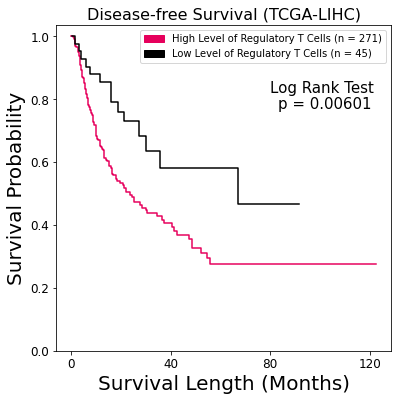

In [15]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,121,40),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of Regulatory T Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Regulatory T Cells (n = %s)'%len(E_low))
plt.text(80,0.82, 'Log Rank Test',fontsize=15)
plt.text(83,0.77, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=10)
plt.title('Disease-free Survival (TCGA-LIHC)',fontsize=16)
plt.savefig('TCGA-LIHC.%s.DFS.pdf'%selected_cell,format='pdf')

In [16]:
os_data = survival_data.filter(['OS.time', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS']]
os_data['OS_T'] = [time/30 for time in os_data['OS.time']]
os_data.head()

,OS.time,OS,OS_E,OS_T
sample,,,,
TCGA-2Y-A9GS-01,724.0,1,True,24.133333
TCGA-2Y-A9GT-01,1624.0,1,True,54.133333
TCGA-2Y-A9GU-01,1939.0,0,False,64.633333
TCGA-2Y-A9GV-01,2532.0,1,True,84.400000
TCGA-2Y-A9GW-01,1271.0,1,True,42.366667


In [17]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,OS.time,OS,OS_E,OS_T
TCGA-FV-A495-01,0.061526,0.036791,0.688189,0.098637,0.058827,0.009298,0.044200,0.002532,0,0.886827,0.467952,1.0,0,False,0.033333
TCGA-CC-A3MB-01,0.139905,0.032341,0.480762,0.118661,0.094536,0.044451,0.085290,0.004055,0,0.842832,0.582837,315.0,1,True,10.500000
TCGA-BC-A3KF-01,0.114993,0.041077,0.596361,0.083589,0.062153,0.032894,0.067308,0.001626,0,0.791911,0.613901,8.0,0,False,0.266667
TCGA-DD-A4NV-01,0.098896,0.002426,0.660500,0.058329,0.102381,0.027923,0.048503,0.001041,0,0.849245,0.532237,2398.0,0,False,79.933333
TCGA-CC-A1HT-01,0.049722,0.125314,0.124946,0.306282,0.066158,0.041490,0.285777,0.000310,0,0.588385,0.868008,101.0,1,True,3.366667


In [18]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,OS.time,OS,OS_E,OS_T
TCGA-BC-A10Q-01,0.071704,0.210038,0.010057,0.264850,0.111290,0.092188,0.239873,0.000000,0,0.379662,0.946914,1135.0,1,True,37.833333
TCGA-DD-A3A6-01,0.000000,0.193165,0.000000,0.444336,0.082710,0.031356,0.248434,0.000000,0,0.196112,0.982878,3258.0,1,True,108.600000
TCGA-ED-A82E-01,0.069451,0.189070,0.007926,0.284670,0.187896,0.073192,0.187795,0.000000,0,0.243913,0.975363,408.0,0,False,13.600000
TCGA-CC-A7II-01,0.115096,0.168123,0.081216,0.320089,0.029653,0.130580,0.154723,0.000521,0,0.551107,0.906259,399.0,0,False,13.300000
TCGA-DD-AA3A-01,0.041634,0.162648,0.049325,0.274810,0.222474,0.111505,0.137604,0.000000,0,0.401834,0.946114,410.0,1,True,13.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-2Y-A9H6-01,0.125409,0.000000,0.646052,0.060470,0.106046,0.022728,0.038386,0.000910,0,0.824845,0.568586,357.0,0,False,11.900000
TCGA-BC-A10X-01,0.122474,0.000000,0.671791,0.020117,0.105170,0.005781,0.071235,0.003433,0,0.868095,0.501374,770.0,1,True,25.666667
TCGA-DD-AAD1-01,0.150369,0.000000,0.483903,0.088561,0.146770,0.034714,0.095270,0.000414,0,0.715583,0.704851,564.0,0,False,18.800000
TCGA-DD-A4NS-01,0.139359,0.000000,0.526923,0.074588,0.116654,0.014893,0.127357,0.000225,0,0.829122,0.579710,2456.0,1,True,81.866667


In [19]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [20]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
#optimization = int(len(E)/2)

In [21]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

0.0657396391734185

In [22]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.0001

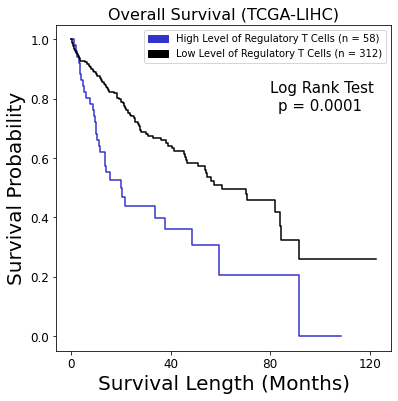

In [23]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,121,40),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of Regulatory T Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Regulatory T Cells (n = %s)'%len(E_low))
plt.text(80,0.82, 'Log Rank Test',fontsize=15)
plt.text(83,0.76, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=10)
plt.title('Overall Survival (TCGA-LIHC)',fontsize=16)
plt.savefig('TCGA-LIHC.%s.OS.pdf'%selected_cell,format='pdf')

In [24]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

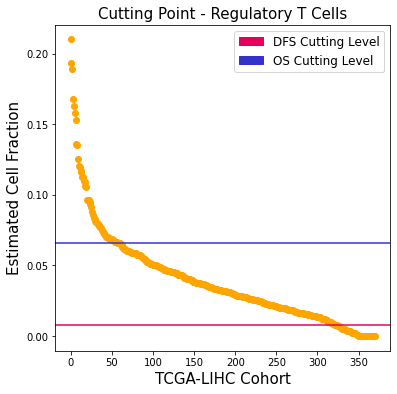

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.xlabel('TCGA-LIHC Cohort',fontsize=15)
plt.title('Cutting Point - Regulatory T Cells',fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
#plt.yscale("log")
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')